# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [1]:
%pip install tensorflow --upgrade
%pip install keras --upgrade

import numpy as np
from matplotlib import pyplot as pl

from skimage.feature import hog
from skimage import data, color, exposure

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2024-05-03 17:08:48.493336: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 17:08:49.347789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Load the `mnist` dataset and normalize in the range [0, 1]

In [94]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [95]:
n_orientations = 16
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [96]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

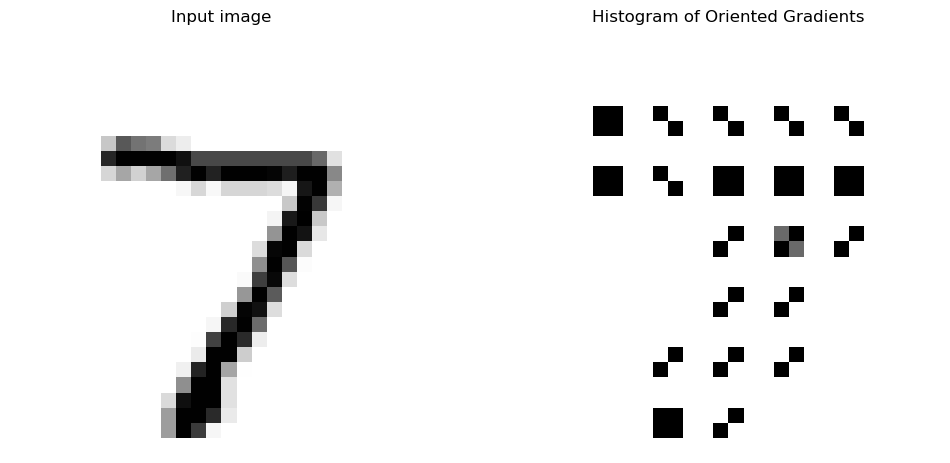

In [97]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets


In [98]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


In [99]:
hog_size

784

Create the MLP

In [105]:
model = Sequential()
model.add(Dense(64, input_shape=(hog_size,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()


/home/sainane/anaconda3/envs/arn/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

Define some constants and train the MLP

In [101]:
batch_size = 128
n_epoch = 20

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_split=0.1)

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7446 - loss: 0.9122 - val_accuracy: 0.9712 - val_loss: 0.1045
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9397 - loss: 0.2096 - val_accuracy: 0.9742 - val_loss: 0.0826
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9526 - loss: 0.1591 - val_accuracy: 0.9755 - val_loss: 0.0746
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9572 - loss: 0.1422 - val_accuracy: 0.9785 - val_loss: 0.0691
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9615 - loss: 0.1299 - val_accuracy: 0.9777 - val_loss: 0.0682
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9642 - loss: 0.1158 - val_accuracy: 0.9780 - val_loss: 0.0689
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9666 - loss: 0.1096 - val_accuracy: 0.9798 - val_loss: 0.0692
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9675 - loss: 0.1087 - val_accuracy: 0.

Show the performance of the model

Test score: 0.07377872616052628
Test accuracy: 0.9793999791145325


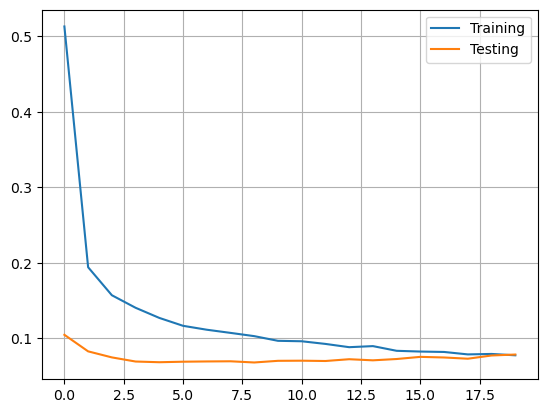

In [102]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

In [103]:
from sklearn.metrics import confusion_matrix

pred = model.predict(X_test_hog)
pred = np.argmax(pred, axis=-1)
confusion_matrix(y_test, pred)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step


array([[ 969,    1,    1,    0,    0,    3,    2,    1,    2,    1],
       [   0, 1125,    2,    3,    0,    0,    3,    1,    1,    0],
       [   2,    4, 1009,    4,    1,    0,    0,    6,    6,    0],
       [   0,    1,    0,  986,    0,    9,    0,    5,    9,    0],
       [   0,    3,    2,    1,  966,    0,    1,    1,    2,    6],
       [   1,    0,    1,    8,    0,  874,    3,    1,    3,    1],
       [   6,    1,    0,    0,    2,    4,  941,    0,    4,    0],
       [   1,    2,    4,    3,    5,    0,    0, 1003,    3,    7],
       [   5,    2,    0,    5,    2,    0,    2,    4,  947,    7],
       [   1,    4,    0,    6,    9,    4,    0,    6,    5,  974]])

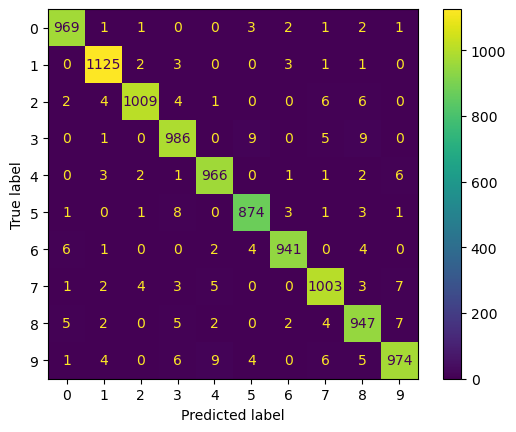

In [104]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred))
disp.plot()
pl.show()